## Importing Libraries
This section imports all the required libraries for data manipulation, visualization, preprocessing, model training, and evaluation.



In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier


In [ ]:
## 

In [3]:
# Load the dataset
url = r"C:\Users\Sonymaths\Downloads\archive\WA_Fn-UseC_-HR-Employee-Attrition.csv"
df = pd.read_csv(url)


In [4]:

# Define numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).drop(columns=['Attrition']).columns.tolist()

# Preprocessing pipeline for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply the transformations
X = df.drop(columns=['Attrition'])
y = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

X_processed = preprocessor.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
   

C:\New folder\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
# Define the Gradient Boosting model
gbm = GradientBoostingClassifier(random_state=42)

# Define the hyperparameter grid
param_grid_gbm = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'max_depth': [3, 5, 7]
}

# Perform grid search with cross-validation
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_gbm = GridSearchCV(gbm, param_grid_gbm, cv=strat_kfold, scoring='f1', return_train_score=True)
grid_search_gbm.fit(X_train_res, y_train_res)

# Best Gradient Boosting model
best_gbm = grid_search_gbm.best_estimator_
print(f"Gradient Boosting Best Params: {grid_search_gbm.best_params_}")


Gradient Boosting Best Params: {'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 100}


In [9]:
# Evaluate the best Gradient Boosting model
y_pred = best_gbm.predict(X_test)
y_prob = best_gbm.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8844
Precision: 0.6316
Recall: 0.3077
F1 Score: 0.4138
ROC-AUC Score: 0.7733
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       255
           1       0.63      0.31      0.41        39

    accuracy                           0.88       294
   macro avg       0.77      0.64      0.67       294
weighted avg       0.87      0.88      0.87       294

Confusion Matrix:
[[248   7]
 [ 27  12]]


In [10]:
# Cross-validation scores
cv_results = cross_val_score(best_gbm, X_train_res, y_train_res, cv=strat_kfold, scoring='f1')

print(f"Cross-Validation F1 Scores: {cv_results}")
print(f"Mean CV F1 Score: {cv_results.mean():.4f}")
print(f"Standard Deviation of CV F1 Scores: {cv_results.std():.4f}")


Cross-Validation F1 Scores: [0.92105263 0.93085106 0.92513369 0.93472585 0.96124031]
Mean CV F1 Score: 0.9346
Standard Deviation of CV F1 Scores: 0.0141


In [11]:
# Get feature names after preprocessing
num_features = numerical_cols
cat_features = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([num_features, cat_features])

# Get feature importances from the Gradient Boosting model
feature_importances = best_gbm.feature_importances_

# Create a DataFrame for feature importances
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sort by importance
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("\nTop 10 Features:")
print(feat_importance_df.head(10))



Top 10 Features:
                             Feature  Importance
46                      OverTime_Yes    0.338516
9                           JobLevel    0.092656
18                  StockOptionLevel    0.065285
45              MaritalStatus_Single    0.043539
5                     EmployeeNumber    0.038504
10                   JobSatisfaction    0.030120
26  BusinessTravel_Travel_Frequently    0.027699
8                     JobInvolvement    0.027532
2                   DistanceFromHome    0.026133
42           JobRole_Sales Executive    0.025509


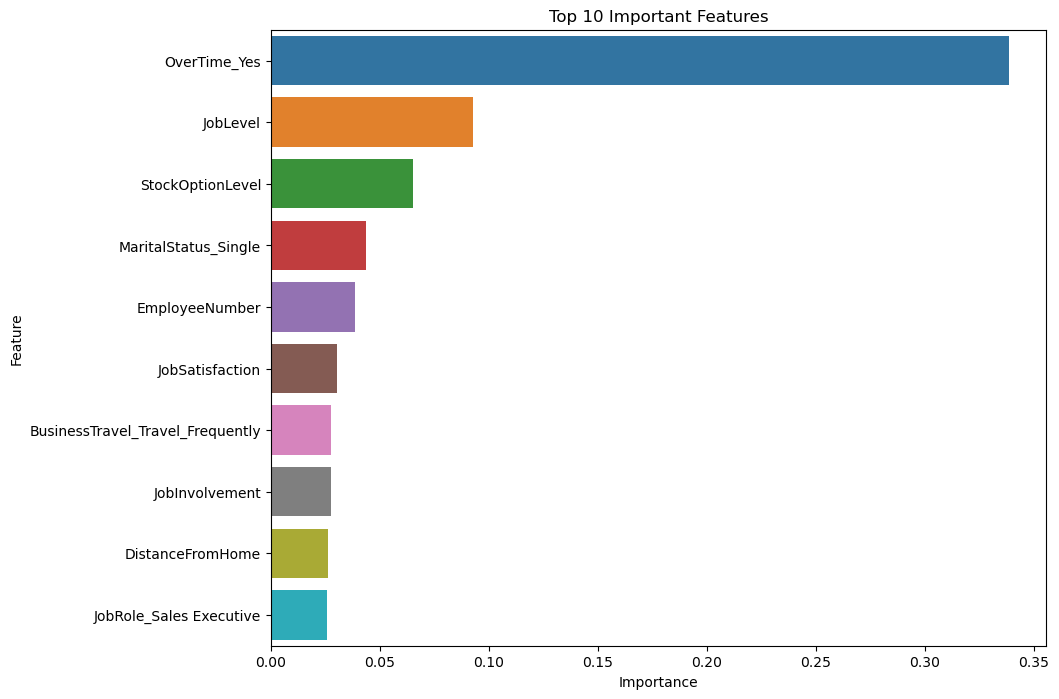

In [12]:
# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(10))
plt.title('Top 10 Important Features')
plt.show()
